Import packages 

In [1]:
#Importing packages
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

Load MNIST Data

In [2]:
#MNIST Dataset has 70000 instances of hand written digits from 0-9, each image size is 28*28
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Define the Hyperparameter & Data info

In [3]:
#Learning Rate, Iterations, Batch Size Hyperparameters
learning_rate = 0.001
iterations = 10000
batch_size = 128
#dropout = 0.5
#epochs = 10

Data Preparation

In [4]:
#Get the data ready for training
#Convert to Float
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

#Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, 784]), x_test.reshape([-1, 784])

#Normalize images value from [0, 255] to [0, 1].
x_train = x_train / 255.
x_test =  x_test / 255.

#Use Tensorflow data for shuffling and fetching it batchwise
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

Define the model

In [5]:
class NeuralNet(Model):
    
    def __init__(self, use_dp = True):
        super(NeuralNet, self).__init__()
        self.use_dp = use_dp
        
        self.L1 = layers.Dense(512, activation = tf.nn.relu, kernel_regularizer = tf.keras.regularizers.l2(0.001))
        self.L2 = layers.Dense(256, activation = tf.nn.relu, kernel_regularizer = tf.keras.regularizers.l2(0.001))
        if self.use_dp:
            self.dp = layers.Dropout(0.5)
        self.Yhat = layers.Dense(10)

    # Set forward pass.
    def call(self, x, is_training = False, use_dp = True):
        x = self.L1(x)
        if self.use_dp:
            x = self.dp(x)
        x = self.L2(x)
        if self.use_dp:
            x = self.dp(x)
        x = self.Yhat(x)
        if not is_training:
            x = tf.nn.softmax(x)
        return x

# Build the network
model = NeuralNet()

Define the cost function

In [6]:
#Cost function definition, using the softmax cross entropy loss
def cross_entropy(y_pred, y_true):
    
    y_true = tf.cast(y_true, tf.int64)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y_true, logits = y_pred)
    
    return tf.reduce_mean(loss)

Metrics to check predictions

In [7]:
#To verify the predictions
def accuracy(y_pred, y_true):
    
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    a = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)
    
    return a

Define the optimizer

In [8]:
#Setup the optimizer function with learning rate as parameter
optimizer = tf.optimizers.Adam(learning_rate)

Put it all together (Optimization of the network)

In [9]:
def run(X, Y):
    
    #Using GradientTape for automatic differentiation.
    with tf.GradientTape() as tape:
        pred = model(X, is_training = True, use_dp = True)
        loss = cross_entropy(pred, Y)
        
    #Get W and B values 
    train_variables = model.trainable_variables
    
    #Compute gradients.
    gradients = tape.gradient(loss, train_variables)
    
    #Update W and b following gradients
    optimizer.apply_gradients(zip(gradients, train_variables))

Let's train for 10000 iterations

In [10]:
#Run the for-loop for a well defined number of epochs

s = time.clock()
loss_plot = []
accuracy_plot = []

for i, (Batch_x, Batch_y) in enumerate(train_data.take(10001), 1):
    # Run the optimization to update W and b values.
    run(Batch_x, Batch_y)
    
    if i % 1000 == 0:
        pred = model(Batch_x, is_training = True, use_dp = False)
        loss = cross_entropy(pred, Batch_y)
        acc = accuracy(pred, Batch_y)
        print('Iteration = {}'.format(i))
        print('Loss = {}'.format(loss))
        print('Accuracy = {}\n'.format(acc))
        
        loss_plot.append(loss)
        accuracy_plot.append(acc)
        
e = time.clock()

print('Time Elapsed = {} \n'.format(e-s))

pred = model(x_test, is_training = False, use_dp = False)
test_accuracy = accuracy(pred, y_test)
print('Accuracy on Test Set is {}'.format(test_accuracy))

C:\Users\Pranav\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


Iteration = 1000
Loss = 0.05459268391132355
Accuracy = 0.96875

Iteration = 2000
Loss = 0.019163331016898155
Accuracy = 1.0

Iteration = 3000
Loss = 0.006705848500132561
Accuracy = 1.0

Iteration = 4000
Loss = 0.01673196069896221
Accuracy = 0.9921875

Iteration = 5000
Loss = 0.001438303617760539
Accuracy = 1.0

Iteration = 6000
Loss = 0.0016540512442588806
Accuracy = 1.0

Iteration = 7000
Loss = 0.00019254360813647509
Accuracy = 1.0

Iteration = 8000
Loss = 0.000503880437463522
Accuracy = 1.0

Iteration = 9000
Loss = 0.003868801984935999
Accuracy = 1.0

Iteration = 10000
Loss = 0.00019916350720450282
Accuracy = 1.0

Time Elapsed = 154.85119400000002 

Accuracy on Test Set is 0.9829000234603882


C:\Users\Pranav\anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Plotting the graph

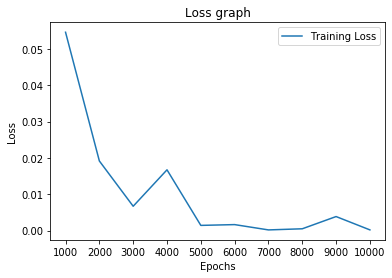

In [11]:
import matplotlib.pyplot as plt
import numpy as np

iterations = np.arange(1000, 10001, 1000)
plt.plot(iterations, loss_plot, label = 'Training Loss')
plt.title('Loss graph')
plt.xlabel('Epochs')
plt.xticks(np.arange(1000, 10001, 1000))
plt.ylabel('Loss')
plt.legend()
plt.show()

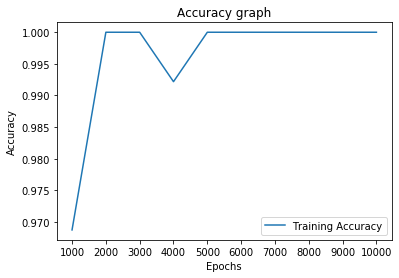

In [12]:
iterations = np.arange(1000, 10001, 1000)
plt.plot(iterations, accuracy_plot, label = 'Training Accuracy')
plt.title('Accuracy graph')
plt.xlabel('Epochs')
plt.xticks(np.arange(1000, 10001, 1000))
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Real Time Predictions

In [13]:
#Import required packages
import numpy as np
from PIL import Image

In [14]:
#Loading, converting and flattening an image for prediction
img = np.invert(Image.open('test_img.png').convert('L')).ravel()
img = img.reshape(1, 784)

(1, 784)
Actual Ground Truth is 2
Prediction for test image is [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


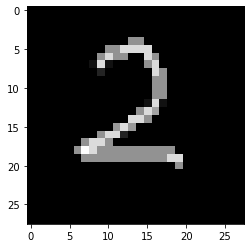

In [15]:
#Passing the loaded image to the neural network
print(img.shape)
prediction = model(img, is_training = False, use_dp = False)
print('Actual Ground Truth is {}'.format(2))
print('Prediction for test image is {}'.format(np.squeeze(prediction)))
plt.imshow(np.reshape(img, [28, 28]), cmap='gray')

Actual Ground Truth is 5
Prediction for test image is [1.9550753e-16 4.9931410e-14 5.1989665e-16 1.1121089e-08 2.4560777e-18
 1.0000000e+00 5.0814572e-13 3.3189925e-15 1.9356550e-12 7.2906688e-11]


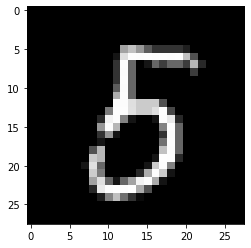

In [16]:
#Prediction using data from the Test Set randomly (We can select the index randomly)
prediction = model(x_test[45].reshape(1, 784), is_training = False, use_dp = False)
print('Actual Ground Truth is {}'.format(np.squeeze(y_test[45])))
print('Prediction for test image is {}'.format(np.squeeze(prediction)))
plt.imshow(np.reshape(x_test[45].reshape(1, 784), [28, 28]), cmap='gray')